In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
#export
from exp.nb_02 import *
import torch.nn.functional as F
import torch.nn as nn

In [4]:
mpl.rcParams['image.cmap'] = 'gray'

In [5]:
x_train, y_train, x_valid, y_valid = load_data()

In [6]:
n, m = x_train.shape
c = y_train.max() + 1
nh = 50

In [7]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in, nh), nn.ReLU(), nn.Linear(nh, n_out)]

    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x


In [8]:
model = Model(m, nh, c)

In [9]:
pred = model(x_train)

### Loss function

<strong>Cross Entropy Loss</strong>

Softmax + negative log likelihood

Model provides output for each class, e^(output_example)
We then sum up the exponents and divide each exponent by the sum.

It's essentially the average of the exponents, which provides a probability for each category.

In [10]:
def log_softmax(x): return (x.exp() / x.exp().sum(-1, keepdim=True)).log()

In [11]:
sm_pred = log_softmax(pred)

Negative Loglikelihood 

2 class scenario:
One has 1-hot encoded values 

```
isCat = 1, isDog = 0, pred_output, logPredCat, logPredDog

NLL = isCat * logPredCat + isDog * logPredDog

```

Better to get the location of the 1 and index into the value, because multiplication by 0 takes time and is wasted effort/computation

Since the xs are 1-hot encoded, the can be rewritten as `-log(p_i)` where i is the index of the desired target.

The trick is to use numpy-style integer array indexing. 

In [12]:
y_train[:3]

tensor([5, 0, 4])

In [13]:
y_train.shape

torch.Size([50000])

In [14]:
sm_pred.shape

torch.Size([50000, 10])

In [15]:
sm_pred[0]

tensor([-2.2242, -2.1641, -2.2862, -2.3178, -2.4674, -2.3353, -2.3832, -2.2771,
        -2.2455, -2.3584], grad_fn=<SelectBackward>)

In [16]:
sm_pred[0].exp().sum()

tensor(1., grad_fn=<SumBackward0>)

In [17]:
sm_pred[[0,1,2], [5,0,4]]

tensor([-2.3353, -2.2113, -2.4207], grad_fn=<IndexBackward>)

In [18]:
y_valid[0]

tensor(3)

In [19]:
x_valid[0].shape

torch.Size([784])

You are indexing into the prediction matrix which in this case is a 50k x 10 matrix. If the target matches the input at row n, nll should return a 0, if not it returns a non-zero value.

In [20]:
# negative log likelihood
def nll(input, target): return -input[range(target.shape[0]), target].mean() 

In [21]:
range(y_train.shape[0])

range(0, 50000)

In [22]:
def log_softmax(x): return x - x.exp().sum(-1, keepdim=True).log()

In [23]:
loss = nll(sm_pred, y_train)
loss

tensor(2.3032, grad_fn=<NegBackward>)

In [24]:
sm_pred.shape

torch.Size([50000, 10])

In [25]:
y_valid[0]

tensor(3)

In [26]:
test_near(nll(log_softmax(pred), y_train), loss)

LogSumExp numerical stability trick

We use this because taking exponents of something can create very large numbers very quickly. Large numbers in floating point are very inaccurate. 
As we depart further away from 0, the computer can confuse numbers even if they are 1000 apart. 

Especially when we're calculating gradients, we don't want big numbers.

In [27]:
# pytorch already has this implemented
def logsumexp(x):
    m = x.max(-1)[0] # in this example max is 255 
    return m + (x - m[:, None]).exp().sum(-1).log()

In [28]:
test_near(logsumexp(pred), pred.logsumexp(-1))

In [29]:
def log_softmax(x): return x - x.logsumexp(-1, keepdim=True)

In [30]:
test_near(nll(log_softmax(pred), y_train), loss)

In [31]:
test_near(F.nll_loss(F.log_softmax(pred, dim=-1), y_train), loss)

In [32]:
test_near(F.cross_entropy(pred, y_train), loss)

In [ ]:
# review the loss functions!!!

In [33]:
loss_func = F.cross_entropy

In [34]:
#export
def accuracy(out, yb): return (torch.argmax(out, dim=1) == yb).float().mean()

In [35]:
bs = 64

# minibatch
xb = x_train[0:bs]
preds = model(xb)
preds[0], preds.shape

(tensor([ 0.0857,  0.1458,  0.0237, -0.0079, -0.1575, -0.0254, -0.0733,  0.0328,
          0.0644, -0.0485], grad_fn=<SelectBackward>),
 torch.Size([64, 10]))

In [36]:
yb = y_train[0:bs]
loss_func(preds, yb)

tensor(2.2993, grad_fn=<NllLossBackward>)

In [37]:
accuracy(preds, yb)

tensor(0.1094)

In [38]:
lr = 0.5
epochs = 1

In [39]:
(50000-1) // bs + 1

782

In [40]:
# examples for batch ranges
for e in range(epochs):
    for i in range((n-1) // bs + 1): # n is 50k, i will range from 0 to n divided by bs
        start_i = i * bs
        end_i = start_i + bs
        print(start_i, end_i)
        if i == 2: break

0 64
64 128
128 192


In [41]:
for e in range(epochs):
    for i in range(n // bs + 1): # loop through batches
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i] # set batch intervals
        yb = y_train[start_i:end_i]
        loss = loss_func(model(xb), yb) # compare batch preds to actuals to calculate loss i.e. forward pass

        loss.backward() # get gradients
        with torch.no_grad():
            for l in model.layers: # loop through layers and adjust weights by gradients w.r.t. loss * learning rate
                if hasattr(l, 'weight'):
                    l.weight -= l.weight.grad * lr 
                    l.bias   -= l.bias.grad * lr
                    l.weight.grad.zero_() # set gradients to 0 - in-place
                    l.bias.grad.zero_()

In [42]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.0659, grad_fn=<NllLossBackward>), tensor(1.))

The first thing we want to do is re-factor the code to update the parameters instead of needing to update the weights and the biases separately.

In [43]:
class DummyModule():
    def __init__(self, n_in, nh, n_out):
        self._modules = {}
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)

    # python method is called everytime one sets self.something
    def __setattr__(self, k, v):
        if not k.startswith("_"): self._modules[k] = v # ignoring the internal python private modules
        super().__setattr__(k, v) # inherit from __setattr__
    
    def __repr__(self): return f'{self._modules}'

    def parameters(self):
        for l in self._modules.values():
            for p in l.parameters(): yield p

In [44]:
mdl = DummyModule(m, nh, 10)
mdl

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [45]:
[o.shape for o in mdl.parameters()]

[torch.Size([50, 784]),
 torch.Size([50]),
 torch.Size([10, 50]),
 torch.Size([10])]

We can use `nn.Module.__setattr__` instead now, which is why we inherit from nn.Module in Pytorch

In [46]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)

    def __call__(self, x): return self.l2(F.relu(self.l1(x)))

In [47]:
model = Model(m, nh, 10)

In [48]:
for name, l in model.named_children(): print(f'{name}: {l}')

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)


In [49]:
model # __rerp__ equivalent

Model(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
)

In [52]:
loss, acc = loss_func(model(xb),yb), accuracy(model(xb), yb)
loss, acc

(tensor(2.3226, grad_fn=<NllLossBackward>), tensor(0.1250))

In [50]:
def fit():
    for e in range(epochs):
        for i in range( (n-1) // bs + 1 ):
            start_i = i*bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            loss = loss_func(model(xb), yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters(): p -= p.grad * lr
                model.zero_grad()

In [53]:
fit()
loss_func(model(xb),yb), accuracy(model(xb), yb)

(tensor(0.0586, grad_fn=<NllLossBackward>), tensor(1.))

In [54]:
# layer list construction
layers = [nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh,10)]

In [55]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i, l in enumerate(self.layers): self.add_module(f'layer_{i}', l)

    def __call__(self, x): 
        for l in self.layers: x = l(x)
        return x

In [56]:
model = Model(layers)
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

In [57]:
# Pytorch version
class SequentialModel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)

    def __call__(self,x):
        for l in self.layers: x = l(x)
        return x


In [58]:
model = SequentialModel(layers)
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [59]:
fit()
loss_func(model(xb),yb), accuracy(model(xb), yb)

(tensor(0.1137, grad_fn=<NllLossBackward>), tensor(0.9375))

In [60]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))

In [61]:
fit()
loss_func(model(xb),yb), accuracy(model(xb), yb)

(tensor(0.1090, grad_fn=<NllLossBackward>), tensor(0.9375))

In [62]:
class Optimizer():
    def __init__(self, params, lr=0.5):
        self.params, self.lr = params, lr

    def step(self):
        with torch.no_grad():
            for p in self.params: p -= p.grad * self.lr

    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [63]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))

In [64]:
loss, acc = loss_func(model(xb),yb), accuracy(model(xb), yb)
loss, acc

(tensor(2.3511, grad_fn=<NllLossBackward>), tensor(0.0625))

In [65]:
#export 
from torch import optim

In [66]:
def get_model():
    model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))
    return model, optim.SGD(model.parameters(), lr=lr)

In [67]:
model, opt = get_model()
loss_func(model(xb), yb)

tensor(2.3108, grad_fn=<NllLossBackward>)

In [68]:
for e in range(epochs):
    for i in range( (n-1) // bs + 1 ):
        start_i = i*bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

In [69]:
loss, acc = loss_func(model(xb),yb), accuracy(model(xb), yb)
loss, acc

(tensor(0.2268, grad_fn=<NllLossBackward>), tensor(0.9375))

In [70]:
assert acc>0.7

In [71]:
#export 
class Dataset():
    def __init__(self, x, y): self.x, self.y = x, y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i], self.y[i]

In [72]:
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)

In [73]:
y_train.shape

torch.Size([50000])

In [74]:
assert len(train_ds) == len(x_train)
assert len(valid_ds) == len(x_valid)

In [76]:
xb, yb = train_ds[0:5]
assert xb.shape == (5, 28*28)
assert yb.shape == (5,)
xb, yb

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([5, 0, 4, 1, 9]))

In [77]:
model, opt = get_model()

In [78]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        xb, yb = train_ds[i*bs:i*bs+bs] # start_i = i * bs, end_i = start_i + bs or i * bs + bs
        preds = model(xb)
        loss = loss_func(preds, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

In [79]:
loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc > 0.7
loss, acc

(tensor(0.4317, grad_fn=<NllLossBackward>), tensor(0.9375))

In [80]:
class DataLoader():
    def __init__(self, ds, bs): self.ds, self.bs = ds, bs
    # iterator func
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs): yield self.ds[i:i+self.bs] # equivalent of calling next(iterator)

In [81]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)

In [82]:
xb, yb = next(iter(valid_dl))
assert xb.shape==(bs, 28*28)
assert yb.shape==(bs,)

tensor(3)

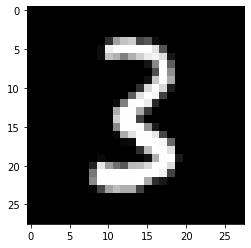

In [83]:
plt.imshow(xb[0].view(28,28))
yb[0]

In [92]:
model, opt = get_model()

In [93]:
def fit():
    for epoch in range(epochs):
        for xb,yb in train_dl:
            preds = model(xb)
            loss = loss_func(preds, yb)

            loss.backward()
            opt.step()
            opt.zero_grad()

In [94]:
fit()

In [95]:
loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc > 0.7
loss, acc

(tensor(0.1103, grad_fn=<NllLossBackward>), tensor(0.9844))

### Random sampler

We want a randomized training set and a non-randomized validation set.

In [97]:
class Sampler():
    def __init__(self, ds, bs, shuffle=False):
        self.n, self.bs, self.shuffle = len(ds), bs, shuffle
    
    def __iter__(self):
        self.idxs = torch.randperm(self.n) if self.shuffle else torch.arange(self.n)
        for i in range(0, self.n, self.bs): yield self.idxs[i:i+self.bs]

In [102]:
sml_ds = Dataset(*train_ds[:10])

In [103]:
s = Sampler(sml_ds, 3, False)
[o for o in s]

[tensor([0, 1, 2]), tensor([3, 4, 5]), tensor([6, 7, 8]), tensor([9])]

In [104]:
s = Sampler(sml_ds, 3, True)
[o for o in s]

[tensor([8, 3, 6]), tensor([2, 1, 7]), tensor([0, 5, 4]), tensor([9])]

In [107]:
def collate(b):
    xs, ys = zip(*b)
    return torch.stack(xs), torch.stack(ys)

class DataLoader():
    def __init__(self, ds, sampler, collate_fn=collate):
        self.ds, self.sampler, self.collate_fn = ds, sampler, collate_fn
    
    def __iter__(self):
        for s in self.sampler: yield self.collate_fn([self.ds[i] for i in s])

In [108]:
train_samp = Sampler(train_ds, bs, True)
valid_samp = Sampler(valid_ds, bs, False)

In [109]:
train_dl = DataLoader(train_ds, sampler=train_samp)
valid_dl = DataLoader(valid_ds, sampler=valid_samp)

tensor(3)

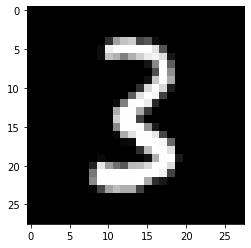

In [110]:
xb, yb = next(iter(valid_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

In [111]:
yb

tensor([3, 8, 6, 9, 6, 4, 5, 3, 8, 4, 5, 2, 3, 8, 4, 8, 1, 5, 0, 5, 9, 7, 4, 1,
        0, 3, 0, 6, 2, 9, 9, 4, 1, 3, 6, 8, 0, 7, 7, 6, 8, 9, 0, 3, 8, 3, 7, 7,
        8, 4, 4, 1, 2, 9, 8, 1, 1, 0, 6, 6, 5, 0, 1, 1])

tensor(7)

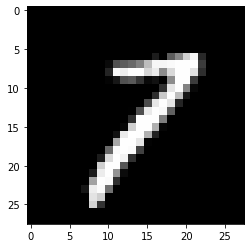

In [114]:
xb, yb = next(iter(train_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

In [115]:
model, opt = get_model()
fit()


loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc > 0.7
loss, acc

(tensor(0.2200, grad_fn=<NllLossBackward>), tensor(0.9375))

## Pytorch DataLoader

In [116]:
#export
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

In [117]:
train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds), collate_fn=collate)
valid_dl = DataLoader(valid_ds, bs, sampler=SequentialSampler(valid_ds), collate_fn=collate)

In [118]:
model, opt = get_model()
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.1538, grad_fn=<NllLossBackward>), tensor(0.9688))

In [126]:
train_dl = DataLoader(train_ds, bs, shuffle=True, drop_last=True)
valid_dl = DataLoader(valid_ds, bs, shuffle=False)

In [127]:
model,opt = get_model()
fit()

loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.2228, grad_fn=<NllLossBackward>), tensor(0.9375))

## Validation

In [130]:
def fit(epochs, model, loss_func, opt, trail_dn, valid_dl):
    for e in range(epochs):
        # Handle batchnorm / dropout
        model.train()
        # print(model.training)
        for xb, yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

        # eval start
        model.eval()
        with torch.no_grad():
            tot_loss, tot_acc = 0., 0. 
            for xb, yb in valid_dl:
                preds = model(xb)
                tot_loss += loss_func(preds, yb)
                tot_acc += accuracy(preds, yb)
        nv = len(valid_dl)
        print( e, tot_loss/nv, tot_acc/nv)
    return tot_loss/nv, tot_acc/nv

In [131]:
#export 
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),DataLoader(valid_ds, batch_size=bs*2, **kwargs))

In [132]:
train_dl, valid_dl = get_dls(train_ds, valid_ds, bs)
model, opt = get_model()
loss, acc = fit(5, model, loss_func, opt, train_dl, valid_dl)

0 tensor(0.1471) tensor(0.9548)
1 tensor(0.1070) tensor(0.9687)
2 tensor(0.1228) tensor(0.9638)
3 tensor(0.1213) tensor(0.9634)
4 tensor(0.1093) tensor(0.9676)


In [133]:
assert acc > 0.9

In [135]:
!python notebook2script.py 03_minibatch_training.ipynb

Converted 03_minibatch_training.ipynb to exp/nb_03.py
